### Model preparation

In [28]:
import torch
import torch.nn as nn
from PIL import Image
import os
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix
from torchvision.models import densenet121, densenet169
from torch.utils.data import Dataset
from torchvision import transforms

num_classes = 10

model = densenet121()

model.classifier = nn.Linear(model.classifier.in_features, num_classes)

'''
model.classifier = nn.Sequential(
    nn.Linear(model.classifier.in_features, 512),
    nn.ReLU(),
    nn.Dropout(p=0.3),   # Dropout layer
    nn.Linear(512, num_classes)
)
'''


'\nmodel.classifier = nn.Sequential(\n    nn.Linear(model.classifier.in_features, 512),\n    nn.ReLU(),\n    nn.Dropout(p=0.3),   # Dropout layer\n    nn.Linear(512, num_classes)\n)\n'

### Dataset preparation

In [29]:
import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset

class SpectrogramDataset(Dataset):
    def __init__(self, dataframe=None, csv_file=None, root_dir=None, transform=None, label_map=None):
        if dataframe is not None:
            self.annotations = dataframe.reset_index(drop=True)
        elif csv_file is not None:
            self.annotations = pd.read_csv(csv_file)
        else:
            raise ValueError("This should be either dataframe or csv!")

        self.root_dir = root_dir
        self.transform = transform
        self.label_map = label_map or self._build_label_map()

    def _build_label_map(self):
        labels = self.annotations['genre'].unique()
        return {label: idx for idx, label in enumerate(sorted(labels))}

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        filename = self.annotations.iloc[idx, 0]
        subfolder = filename.split('.')[0]
        filename = filename[:-4] + '.png'
        img_name = os.path.join(self.root_dir, subfolder, filename)

        image = Image.open(img_name).convert('RGB')
        label_str = self.annotations.iloc[idx, 1]
        label = self.label_map[label_str]

        if self.transform:
            image = self.transform(image)

        return image, label


In [30]:
'''
from sklearn.model_selection import train_test_split
csv_file = 'project_data/tracks.csv'
df = pd.read_csv(csv_file)
df = df.sample(frac=1).reset_index(drop=True)
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['genre'])
valid_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['genre'])

train_df.to_csv('densenet_dataset_split/train.csv', index=False)
valid_df.to_csv('densenet_dataset_split/valid.csv', index=False)
test_df.to_csv('densenet_dataset_split/test.csv', index=False)

print("Data has been split into train.csv, valid.csv, and test.csv with balanced genres.")
'''

'\nfrom sklearn.model_selection import train_test_split\ncsv_file = \'project_data/tracks.csv\'\ndf = pd.read_csv(csv_file)\ndf = df.sample(frac=1).reset_index(drop=True)\ntrain_df, temp_df = train_test_split(df, test_size=0.3, stratify=df[\'genre\'])\nvalid_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df[\'genre\'])\n\ntrain_df.to_csv(\'densenet_dataset_split/train.csv\', index=False)\nvalid_df.to_csv(\'densenet_dataset_split/valid.csv\', index=False)\ntest_df.to_csv(\'densenet_dataset_split/test.csv\', index=False)\n\nprint("Data has been split into train.csv, valid.csv, and test.csv with balanced genres.")\n'

In [31]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_dataset = SpectrogramDataset(
    csv_file='densenet_dataset_split/train.csv',
    root_dir='../project_data/spectrograms',
    transform=transform
)

val_dataset = SpectrogramDataset(
    csv_file='densenet_dataset_split/valid.csv',
    root_dir='../project_data/spectrograms',
    transform=transform
)

test_dataset = SpectrogramDataset(
    csv_file='densenet_dataset_split/test.csv',
    root_dir='../project_data/spectrograms',
    transform=transform
)

cross_val_dataset = SpectrogramDataset(
    csv_file='densenet_dataset_split/cross_val.csv',
    root_dir='../project_data/spectrograms',
    transform=transform
)

In [32]:
#validation
image, label = train_dataset[1]
print(image.shape)
print(label)
print(train_dataset.label_map)


torch.Size([3, 224, 224])
6
{'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}


In [33]:
print(torch.__version__)
print(torch.version.cuda)
print(torch.backends.cudnn.version())

if torch.cuda.is_available():
    print(f"CUDA is available. Using GPU: {torch.cuda.get_device_name(0)}")
else: 
    print("CUDA is not available. Using CPU.")

2.5.1+cu121
12.1
90100
CUDA is available. Using GPU: NVIDIA GeForce GTX 1650


### Model training

In [34]:
def get_filename_with_date(prefix="model", extension="pth"):
    now = datetime.datetime.now()
    date_str = now.strftime("%d_%b_%H_%M")
    return f"{prefix}_{date_str}.{extension}"


class EarlyStopping:
    def __init__(self, patience=5, delta=0.0):
        self.patience = patience
        self.delta = delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_model_state = None

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0
            self.best_model_state = model.state_dict()

In [ ]:
import torch.optim as optim
from torch.utils.data import DataLoader

def optimizer_to(optimizer, device):
    for param_group in optimizer.param_groups:
        for param in param_group['params']:
            param.data = param.data.to(device)
    return optimizer

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, pin_memory=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


start_epoch = 0


train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
train_precisions = []
val_precisions = []


#BELOW: loading existing checkpoint model
'''
optimizer = optimizer_to(optimizer, device)
checkpoint = torch.load('model_densenet169_13_May_19_22.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
start_epoch = checkpoint['epoch']

num_epochs = 25
train_losses = checkpoint['train_losses']
val_losses = checkpoint['val_losses']
train_accuracies = checkpoint['train_accuracies']
val_accuracies = checkpoint['val_accuracies']
train_precisions = checkpoint['train_precisions: ']
val_precisions = checkpoint['val_precisions']
'''


"\noptimizer = optimizer_to(optimizer, device)\ncheckpoint = torch.load('model_densenet169_13_May_19_22.pth', map_location=device)\nmodel.load_state_dict(checkpoint['model_state_dict'])\noptimizer.load_state_dict(checkpoint['optimizer_state_dict'])\nstart_epoch = checkpoint['epoch']\n\nnum_epochs = 25\ntrain_losses = checkpoint['train_losses']\nval_losses = checkpoint['val_losses']\ntrain_accuracies = checkpoint['train_accuracies']\nval_accuracies = checkpoint['val_accuracies']\ntrain_precisions = checkpoint['train_precisions: ']\nval_precisions = checkpoint['val_precisions']\n"

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device, patience=5):

    model = model.to(device, non_blocking=True)
    early_stopping = EarlyStopping(patience=patience, delta=0.001)

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    train_precisions, val_precisions = [], []

    best_model_state = None
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        # --- TRAIN ---
        model.train()
        total_train_loss, correct_train, total_train = 0, 0, 0
        y_train_true, y_train_pred = [], []

        for images, labels in train_loader:
            images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

            y_train_true.extend(labels.cpu().numpy())
            y_train_pred.extend(predicted.cpu().numpy())

        avg_train_loss = total_train_loss / len(train_loader)
        train_accuracy = correct_train / total_train
        train_precision = precision_score(y_train_true, y_train_pred, average='macro', zero_division=0)

        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)
        train_precisions.append(train_precision)

        # --- VALIDATION ---
        model.eval()
        total_val_loss, correct_val, total_val = 0, 0, 0
        y_val_true, y_val_pred = [], []

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
                outputs = model(images)
                total_val_loss += criterion(outputs, labels).item()

                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)

                y_val_true.extend(labels.cpu().numpy())
                y_val_pred.extend(predicted.cpu().numpy())

        avg_val_loss = total_val_loss / len(val_loader)
        val_accuracy = correct_val / total_val
        val_precision = precision_score(y_val_true, y_val_pred, average='macro', zero_division=0)

        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)
        val_precisions.append(val_precision)

        print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Train Acc: {train_accuracy:.4f} | Train Prec: {train_precision:.4f}")
        print(f"Epoch {epoch+1} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.4f} | Val Prec: {val_precision:.4f}")

        # Early stopping
        ''' 
        early_stopping(avg_val_loss, model)
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict()

        if early_stopping.early_stop:
            print(f"⏹️ Early stopping at epoch {epoch+1}")
            break
            
        # Przywróć najlepszy model
        if best_model_state is not None:
            model.load_state_dict(best_model_state)
        '''


    metrics = {
        'train_loss': train_losses,
        'train_accuracy': train_accuracies,
        'train_precision': train_precisions,
        'val_loss': val_losses,
        'val_accuracy': val_accuracies,
        'val_precision': val_precisions
    }

    final_metrics = {
        'train_loss': train_losses[-1],
        'train_accuracy': train_accuracies[-1],
        'train_precision': train_precisions[-1],
        'val_loss': val_losses[-1],
        'val_accuracy': val_accuracies[-1],
        'val_precision': val_precisions[-1]
    }

    return model, metrics, final_metrics

from copy import deepcopy

def run_cross_validation(model_fn, df, root_dir, transform, num_classes,
                         k=5, batch_size=32, epochs=10, lr=1e-4, device='cuda', patience=5):
    from sklearn.model_selection import StratifiedKFold

    X = df['file_name'].values
    y = df['genre'].values
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

    all_fold_metrics = []
    train_losses = []
    train_accuracies =[]
    train_precisions = []
    val_losses = []
    val_accuracies = []
    val_precisions = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        print(f"\n🔁 Fold {fold+1}/{k}")

        # Split
        train_df = df.iloc[train_idx].reset_index(drop=True)
        val_df = df.iloc[val_idx].reset_index(drop=True)

        # Datasets
        train_dataset = SpectrogramDataset(dataframe=train_df, root_dir=root_dir, transform=transform)
        val_dataset = SpectrogramDataset(dataframe=val_df, root_dir=root_dir, transform=transform)

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        # Model
        model = model_fn
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)

        trained_model, metrics, final_metrics = train_model(model, train_loader, val_loader, criterion, optimizer,
                                             num_epochs=epochs, device=device, patience=patience)

        print(f"Fold {fold+1} finished. Metrics: {metrics}")
        all_fold_metrics.append(final_metrics)

        train_losses.append(deepcopy(metrics['train_loss']))
        train_accuracies.append(deepcopy(metrics['train_accuracy']))
        train_precisions.append(deepcopy(metrics['train_precision']))
        val_losses.append(deepcopy(metrics['val_loss']))
        val_accuracies.append(deepcopy(metrics['val_accuracy']))
        val_precisions.append(deepcopy(metrics['val_precision']))

    metrics_all = {
    'train_loss': train_losses,
    'train_accuracy': train_accuracies,
    'train_precision': train_precisions,
    'val_loss': val_losses,
    'val_accuracy': val_accuracies,
    'val_precision': val_precisions
    }

    avg_metrics = {
        key: np.mean([fold[key] for fold in all_fold_metrics])
        for key in all_fold_metrics[0]
    }

    print("Cross-validation average metrics:")
    for k, v in avg_metrics.items():
        print(f"{k}: {v:.4f}")

    return all_fold_metrics, avg_metrics, metrics_all


num_epochs = 3
metrics, avg, all_metrics = run_cross_validation(
    model_fn=model,
    df=pd.read_csv('densenet_dataset_split/cross_val.csv'),
    root_dir='../project_data/spectrograms',
    transform=transform,
    num_classes=10,
    k=2,
    batch_size=32,
    epochs=num_epochs,
    lr=1e-4,
    device='cuda',
    patience=5
)



🔁 Fold 1/2
Epoch 1 | Train Loss: 2.0661 | Train Acc: 0.2776 | Train Prec: 0.2710
Epoch 1 | Val Loss: 2.3243 | Val Acc: 0.1247 | Val Prec: 0.0847
Epoch 2 | Train Loss: 1.6968 | Train Acc: 0.5082 | Train Prec: 0.5470
Epoch 2 | Val Loss: 2.2711 | Val Acc: 0.1600 | Val Prec: 0.1163
Epoch 3 | Train Loss: 1.4776 | Train Acc: 0.5741 | Train Prec: 0.5696
Epoch 3 | Val Loss: 1.6075 | Val Acc: 0.4259 | Val Prec: 0.4482
Fold 1 finished. Metrics: {'train_loss': [2.0660602705819264, 1.6967934284891402, 1.4775984116962977], 'train_accuracy': [0.2776470588235294, 0.508235294117647, 0.5741176470588235], 'train_precision': [0.271008933876581, 0.5469752025847135, 0.5696251120630108], 'val_loss': [2.3242612736565724, 2.271115984235491, 1.607518494129181], 'val_accuracy': [0.12470588235294118, 0.16, 0.4258823529411765], 'val_precision': [0.0846652739992227, 0.11632335890895702, 0.4481857141572667]}

🔁 Fold 2/2
Epoch 1 | Train Loss: 1.4153 | Train Acc: 0.5341 | Train Prec: 0.5252
Epoch 1 | Val Loss: 1.336

In [37]:
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())


Accuracy: 0.6867
Precision (macro): 0.6929
F1 Score (macro): 0.6778
Confusion Matrix:


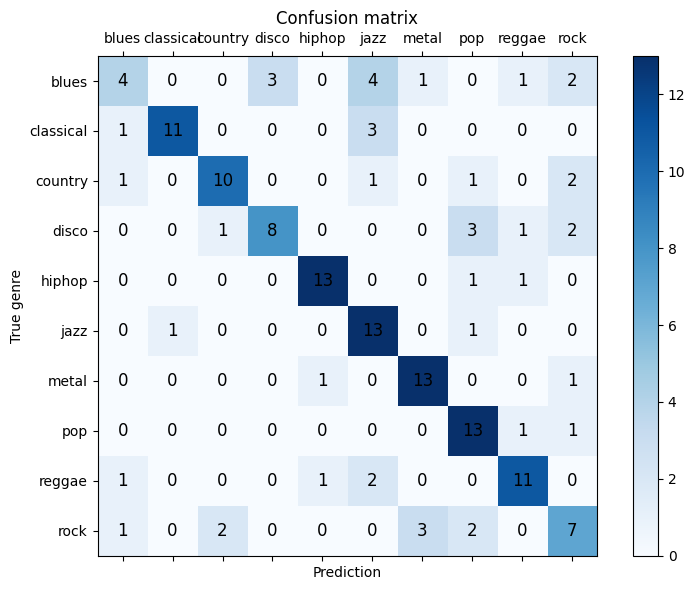

In [38]:
import matplotlib.pyplot as plt
test_accuracy = accuracy_score(y_true, y_pred)
test_precision = precision_score(y_true, y_pred, average='macro')
test_f1 = f1_score(y_true, y_pred, average='macro')
conf_matrix = confusion_matrix(y_true, y_pred)

print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision (macro): {test_precision:.4f}")
print(f"F1 Score (macro): {test_f1:.4f}")
print("Confusion Matrix:")

class_names = test_dataset.label_map.keys()

fig, ax = plt.subplots(figsize=(8, 6))
cax = ax.matshow(conf_matrix, cmap='Blues')
fig.colorbar(cax)
# Dodaj etykiety osi
ax.set_xticks(np.arange(len(class_names)))
ax.set_yticks(np.arange(len(class_names)))
ax.set_xticklabels(class_names)
ax.set_yticklabels(class_names)

# Dodaj liczby do komórek
for i in range(len(conf_matrix)):
    for j in range(len(conf_matrix[i])):
        ax.text(j, i, str(conf_matrix[i][j]),
                va='center', ha='center', color='black', fontsize=12)

# Oznaczenia osi
plt.xlabel('Prediction')
plt.ylabel('True genre')
plt.title('Confusion matrix')
plt.tight_layout()
plt.show()


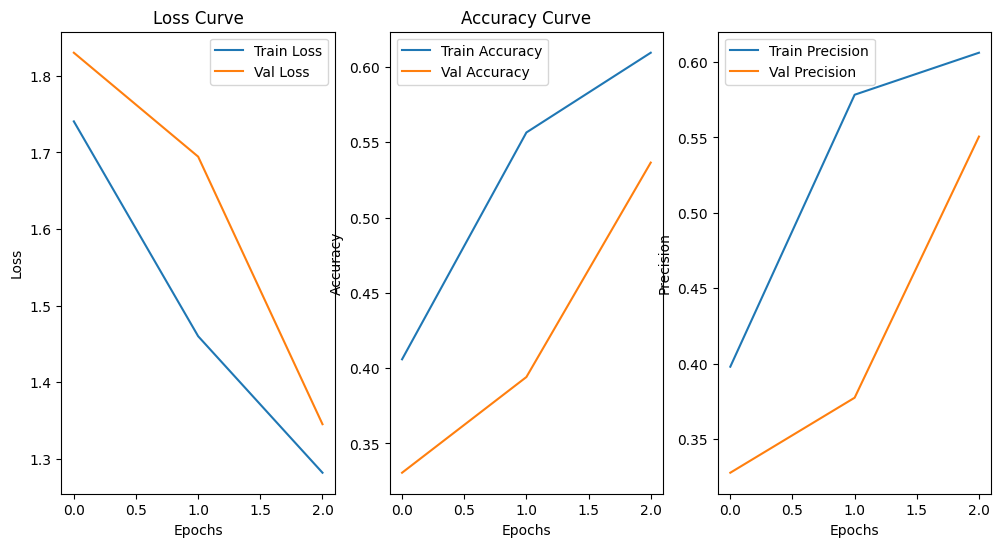

In [47]:
# Plotting the Loss and Accuracy curves
plt.figure(figsize=(12, 6))

num_epochs = 3
# Losses
plt.subplot(1, 3, 1)
plt.plot(range(num_epochs), np.mean(all_metrics['train_loss'], axis=0), label='Train Loss')
plt.plot(range(num_epochs), np.mean(all_metrics['val_loss'], axis=0), label='Val Loss')
plt.title("Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Accuracy
plt.subplot(1, 3, 2)
plt.plot(range(num_epochs), np.mean(all_metrics['train_accuracy'], axis=0), label='Train Accuracy')
plt.plot(range(num_epochs), np.mean(all_metrics['val_accuracy'], axis=0), label='Val Accuracy')
plt.title("Accuracy Curve")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Precision
plt.subplot(1, 3, 3)
plt.plot(range(num_epochs), np.mean(all_metrics['train_precision'], axis=0), label='Train Precision')
plt.plot(range(num_epochs), np.mean(all_metrics['val_precision'], axis=0), label='Val Precision')
plt.title("Precision Curve")
plt.xlabel("Epochs")
plt.ylabel("Precision")
plt.legend()

plt.title('')
plt.show()

In [48]:

torch.save({
    'epoch': num_epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_accuracies': all_metrics['train_accuracy'],
    'val_accuracies': all_metrics['val_accuracy'],
    'train_losses': all_metrics['train_loss'],
    'val_losses': all_metrics['val_loss'],
    'train_precisions: ': all_metrics['train_precision'],
    'val_precisions': all_metrics['val_precision'],
    'test_accuracy' : test_accuracy,
    'test_precision' : test_precision,
    'test_f1': test_f1,
    'conf_matrix': conf_matrix
}, get_filename_with_date())

In [ ]:
'''
torch.save(model.state_dict(), 'model.pth')
'''

In [ ]:
'''

num_classes = 10
model = densenet121()
model.classifier = nn.Linear(model.classifier.in_features, num_classes)
model.load_state_dict(torch.load('model.pth'))
model.eval()
success = 0
val_size = 1
for elem in val_dataset:
    image, label = elem
    with torch.no_grad():
        output = model(image.unsqueeze(0))
    _, predicted = torch.max(output, 1)

    if predicted == label:
        success += 1
    val_size += 1
print(success/val_size)

'''